In [2]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from matplotlib import pyplot as plt

# import scanpy as sc
import scvelo as scv

from statannotations.Annotator import Annotator

In [5]:
seed = 1
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 
sc.logging.print_header()

scanpy==0.1.dev3254+g5b9bc72 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [6]:
os.chdir('/home/wu/datb1/reseq_ppp/Pub_PPP_code')

In [7]:
sns.set_style("white")

In [8]:
adata_ker = ad.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/KC_PPP_10X.h5ad')

In [6]:
adata_ker.obs['batch_group'] = adata_ker.obs.batch_group.cat.reorder_categories(['HC', 'NL', 'Lesion'])
adata_ker.uns['batch_group_colors'] = ['#3182bd', '#31a354', '#fd8d3c']

df_name = adata_ker.obs['batch'].astype(str).str.split("_", expand=True)
df_name.loc[df_name.index.str.contains('PPP'), 1] = df_name.loc[df_name.index.str.contains('PPP'), 1].str.split("C", expand=True)[0]
df_name = df_name[0] + '_' + df_name[1]
# df_name.str.split("C", expand=True)[0]
# df_name[df_name.index.str.contains('PPP_')] = df_name[df_name.index.str.contains('PPP')].str.split("C", expand=True)[0]
adata_ker.obs['patient'] = df_name.copy()
adata_ker.obs['patient'].value_counts()

adata_ker.obs['leiden'] = adata_ker.obs['leiden'].cat.reorder_categories(['Basal KC I', 'Basal KC II', 'Basal KC III', 'Suprabasal KC I', 
                                            'Suprabasal KC II', 'Proliferating KC', 'Stressed KC'])

def map_cell_type(leiden):
    if "Suprabasal" in leiden:
        return "Suprabasal"
    elif "Basal" in leiden:
        return "Basal"
    elif "Stressed" in leiden:
        return "Stressed"
    elif "Proliferating" in leiden:
        return "Proliferating"
    else:
        assert False, f"Unknown cell type: {leiden}"

adata_ker.obs['cell_type'] = adata_ker.obs['leiden'].apply(map_cell_type)
adata_ker.obs['batch_group_cell_type'] = adata_ker.obs['batch_group'].astype(str) + '_' + adata_ker.obs['cell_type'].astype(str)

### Marker gene expression

In [11]:
def check_expression_between_batch_group(adata, gene):
    order=[f"{y}_{x}" for x in ['Basal', 'Suprabasal'] for y in ['HC', 'NL', 'Lesion']]
        
    pairs = [(f"{x}_{z}", f"{y}_{z}") for x in ['HC', 'NL', 'Lesion'] for y in ['HC', 'NL', 'Lesion'] for z in ['Basal', 'Suprabasal'] if x != y]
    
    adata.obs[f"{gene}_exp"] = adata[:, gene].X.toarray().flatten()

    ax = sns.violinplot(data=adata.obs, x="batch_group_cell_type", y=f"{gene}_exp", palette=sns.palettes.color_palette(adata_ker.uns['batch_group_colors']), \
                        order=order, scale='width')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.yaxis.set_ticks_position('left')
    sns.despine()
    annotator = Annotator(ax, pairs=pairs, data=adata.obs, x='batch_group_cell_type', y=f"{gene}_exp", order=order)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', show_test_name=False)
    annotator.apply_and_annotate()
    
    # plt.suptitle(f"{gene} expression in different cell type")
    plt.tight_layout()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.087e-62 U_stat=8.035e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.785e-08 U_stat=3.587e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.087e-62 U_stat=8.035e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.785e-08 U_stat=3.587e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.825e-38 U_stat=1.035e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.220e-39 U_stat=5.229e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.825e-38 U_stat=1.035e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.220e-39 U_stat=5.229e+06
HC_Basal vs

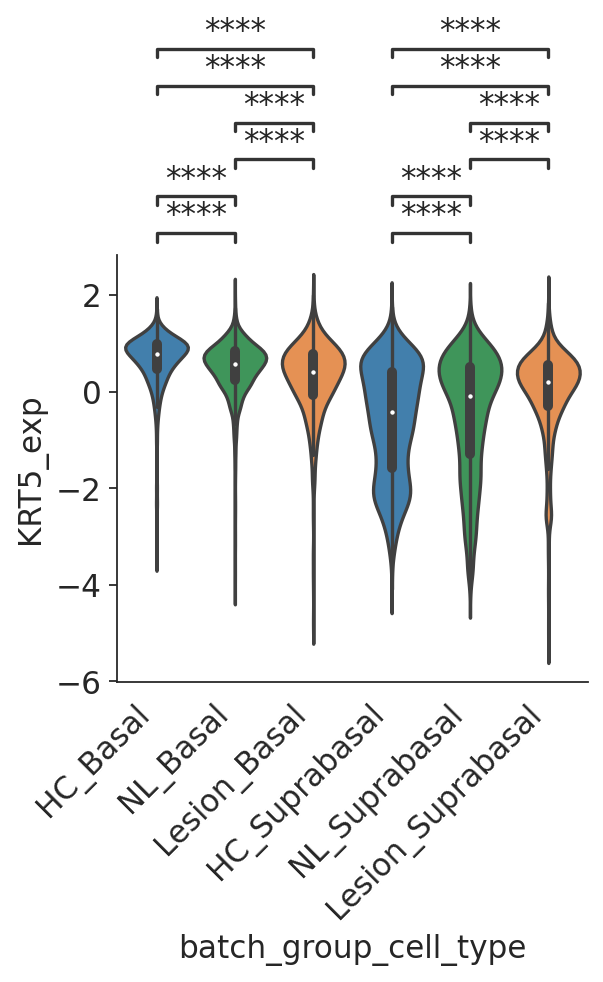

In [12]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'KRT5')
    plt.savefig('figures/fig2_4/KRT5_expression_between_batch_group.pdf')

In [16]:
import pandas as pd
from scipy.stats import mannwhitneyu

# 假设你已经有一个 DataFrame df
# df = pd.DataFrame({
#     'batch_group': ['HC', 'NL', 'Lesion', 'HC', 'NL', 'Lesion', ...],
#     'KRT5_exp': [1.2, 3.4, 5.6, 7.8, 9.0, 1.2, ...]
# })
df = adata_ker.obs.copy()
# 分组数据
hc_exp = df[df['batch_group_cell_type'] == 'HC_Basal']['KRT5_exp']
nl_exp = df[df['batch_group_cell_type'] == 'NL_Basal']['KRT5_exp']
lesion_exp = df[df['batch_group_cell_type'] == 'Lesion_Basal']['KRT5_exp']

# 进行 Wilcoxon rank sum 检验
# HC vs NL
stat_hc_nl, p_hc_nl = mannwhitneyu(hc_exp, nl_exp)
print(f"HC vs NL: Statistic = {stat_hc_nl}, p-value = {p_hc_nl}")

# HC vs Lesion
stat_hc_lesion, p_hc_lesion = mannwhitneyu(hc_exp, lesion_exp)
print(f"HC vs Lesion: Statistic = {stat_hc_lesion}, p-value = {p_hc_lesion}")

# NL vs Lesion
stat_nl_lesion, p_nl_lesion = mannwhitneyu(nl_exp, lesion_exp)
print(f"NL vs Lesion: Statistic = {stat_nl_lesion}, p-value = {p_nl_lesion}")

HC vs NL: Statistic = 8035061.0, p-value = 6.086626954153855e-62
HC vs Lesion: Statistic = 4256133.0, p-value = 4.762084233606186e-108
NL vs Lesion: Statistic = 10351395.0, p-value = 2.825011086166298e-38


In [13]:
adata_ker.obs.KRT5_exp

PPP_P16_foot_10X_AACAGGGCAGTATGAA-1   -1.291105
PPP_P16_foot_10X_AAGCATCGTAGTGTGG-1    0.236199
PPP_P16_foot_10X_AAGCCATAGACCTGGA-1   -0.815688
PPP_P16_foot_10X_ACCTACCCACAAACGG-1    0.291417
PPP_P16_foot_10X_ACGGGTCTCCCGTGAG-1    0.355726
                                         ...   
PPP_P24_foot_10X_TTTGGTTGTGGCCACT-1    1.390805
PPP_P24_foot_10X_TTTGGTTTCAAATAGG-1    0.130211
PPP_P24_foot_10X_TTTGGTTTCTGTCAGA-1   -0.415566
PPP_P24_foot_10X_TTTGTTGTCTCAGGCG-1    0.208099
PPP_P24_foot_10X_TTTGTTGTCTCATGGA-1   -3.792600
Name: KRT5_exp, Length: 26336, dtype: float64

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.105e+07
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.964e-267 U_stat=6.101e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.105e+07
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.964e-267 U_stat=6.101e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:5.279e-30 U_stat=1.014e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.918e-26 U_stat=7.297e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:5.279e-30 U_stat=1.014e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.918e-26 U_stat=7.297e+06
HC_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=5.504e+06
HC_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.458e-299 

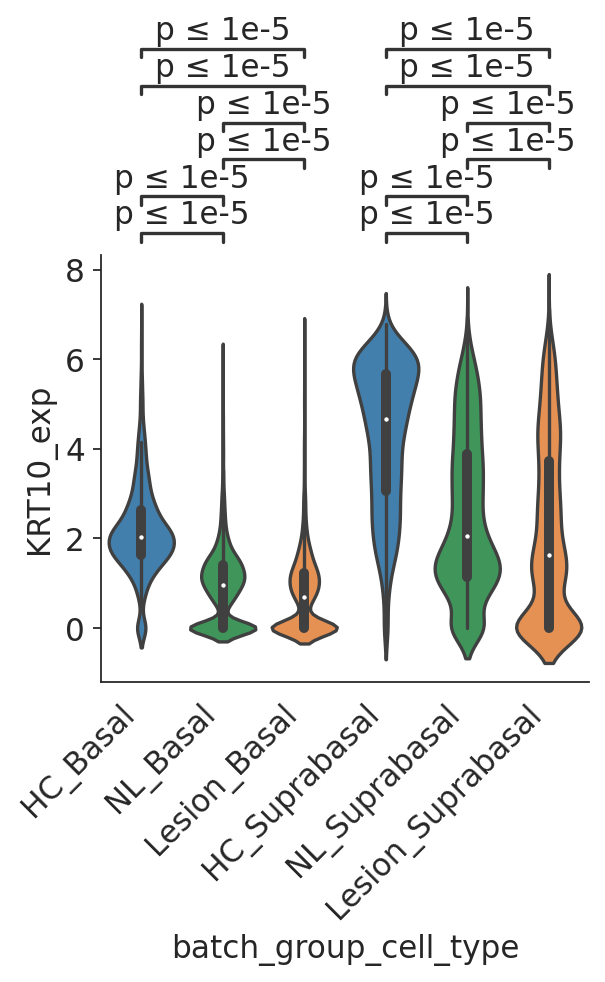

In [50]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'KRT10')
    plt.savefig('figures/fig2_4/KRT10_expression_between_batch_group.pdf')

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.649e-263 U_stat=9.731e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:5.733e-30 U_stat=4.574e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.649e-263 U_stat=9.731e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:5.733e-30 U_stat=4.574e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.224e-20 U_stat=9.933e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.884e-02 U_stat=6.553e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.224e-20 U_stat=9.933e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.884e-02 U_stat=6.553e+06
HC_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.765e-274 U_stat=4.937e+06
HC_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.536e-33 

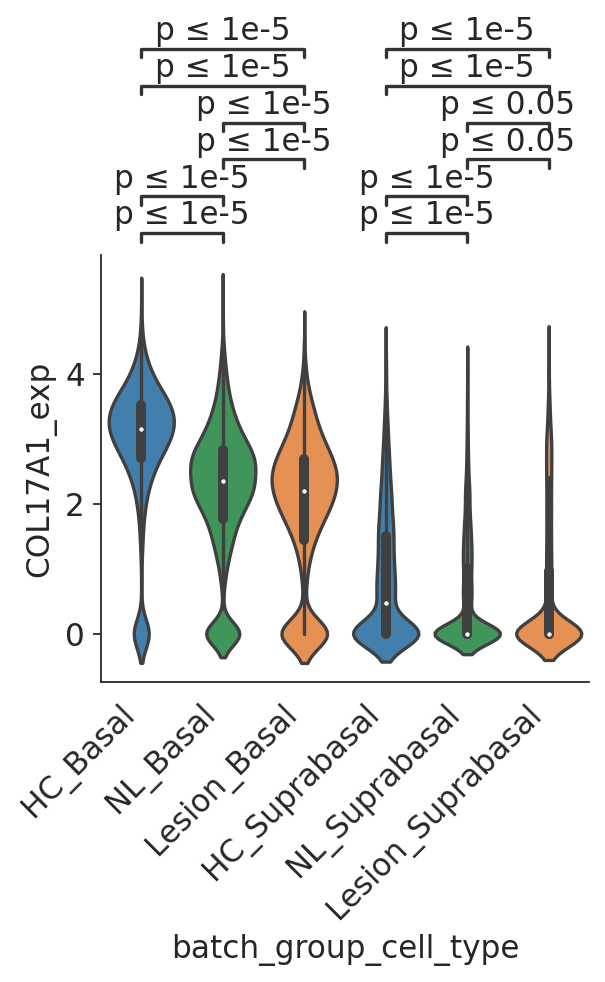

In [51]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'COL17A1')
    plt.savefig('figures/fig2_4/COL17A1_expression_between_batch_group.pdf')

In [52]:
# b-h correction
from statsmodels.stats.multitest import multipletests
multipletests([6.882e-47, 0.1, 0.2], method='fdr_bh', is_sorted=False, returnsorted=False)[1]

array([2.0646e-46, 1.5000e-01, 2.0000e-01])

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.010e+07
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.948e-82 U_stat=5.129e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.010e+07
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.948e-82 U_stat=5.129e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:5.793e-94 U_stat=1.102e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.212e-294 U_stat=9.574e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:5.793e-94 U_stat=1.102e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.212e-294 U_stat=9.574e+06
HC_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=5.389e+06
HC_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U

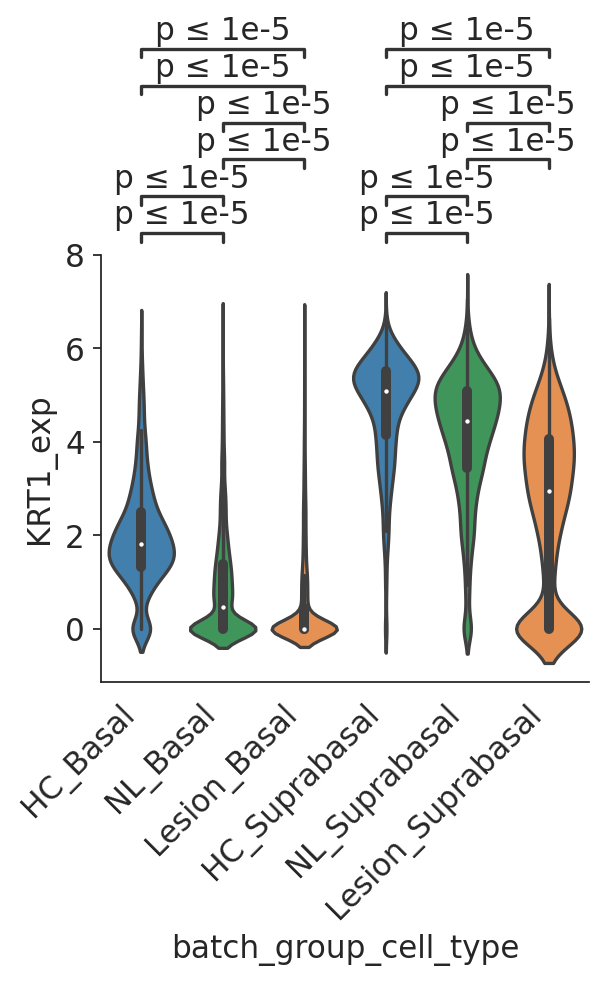

In [53]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'KRT1')
    plt.savefig('figures/fig2_4/KRT1_expression_between_batch_group.pdf')

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.398e-53 U_stat=5.024e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.430e-152 U_stat=2.304e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.398e-53 U_stat=5.024e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.430e-152 U_stat=2.304e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.463e-27 U_stat=1.011e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.377e-39 U_stat=5.234e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.463e-27 U_stat=1.011e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.377e-39 U_stat=5.234e+06
HC_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.493e-04 U_stat=2.928e+06
HC_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U

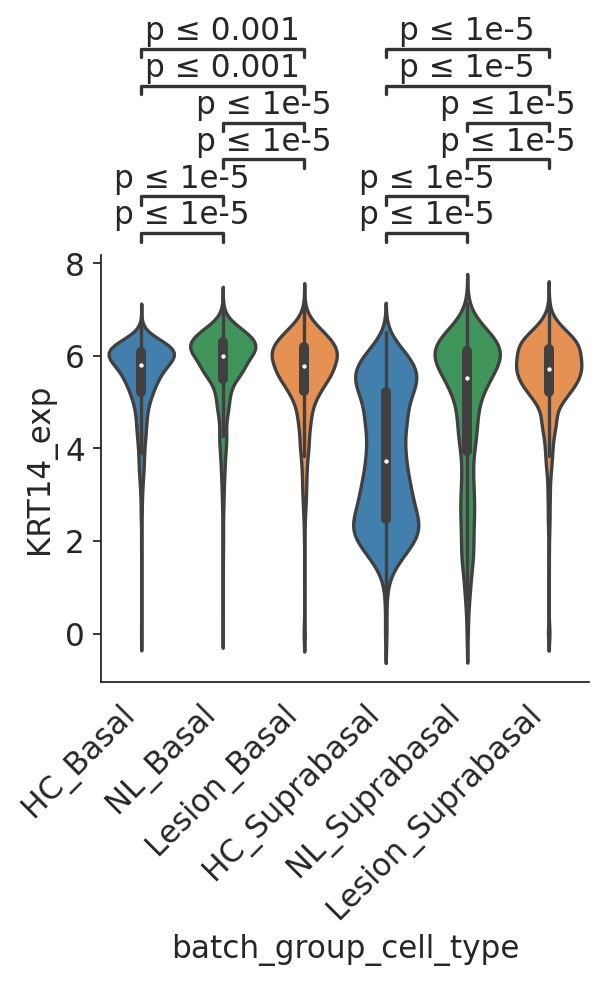

In [54]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'KRT14')
    plt.savefig('figures/fig2_4/KRT14_expression_between_batch_group.pdf')

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.392e-290 U_stat=7.841e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=5.548e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.392e-290 U_stat=7.841e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=5.548e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.357e-01 U_stat=8.849e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:5.805e-01 U_stat=6.368e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.357e-01 U_stat=8.849e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:5.805e-01 U_stat=6.368e+06
HC_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:5.204e-144 U_stat=3.778e+06
HC_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 

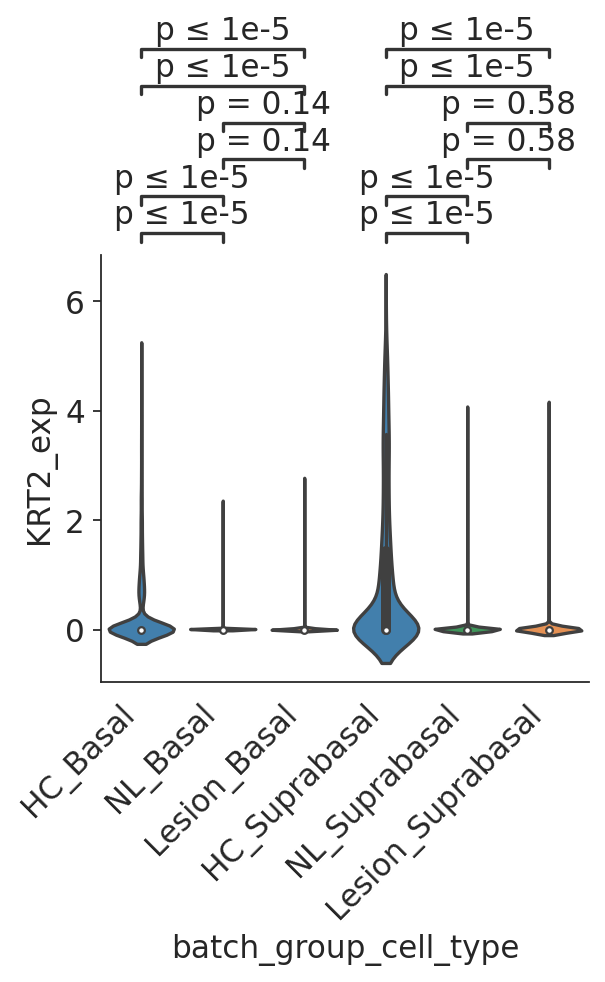

In [55]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'KRT2')
    plt.savefig('figures/fig2_4/KRT2_expression_between_batch_group.pdf')

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:8.315e-161 U_stat=8.780e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.288e-14 U_stat=4.405e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:8.315e-161 U_stat=8.780e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.288e-14 U_stat=4.405e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.013e-196 U_stat=1.152e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.066e+07
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.013e-196 U_stat=1.152e+07
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.066e+07
HC_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=5.078e+06
HC_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00

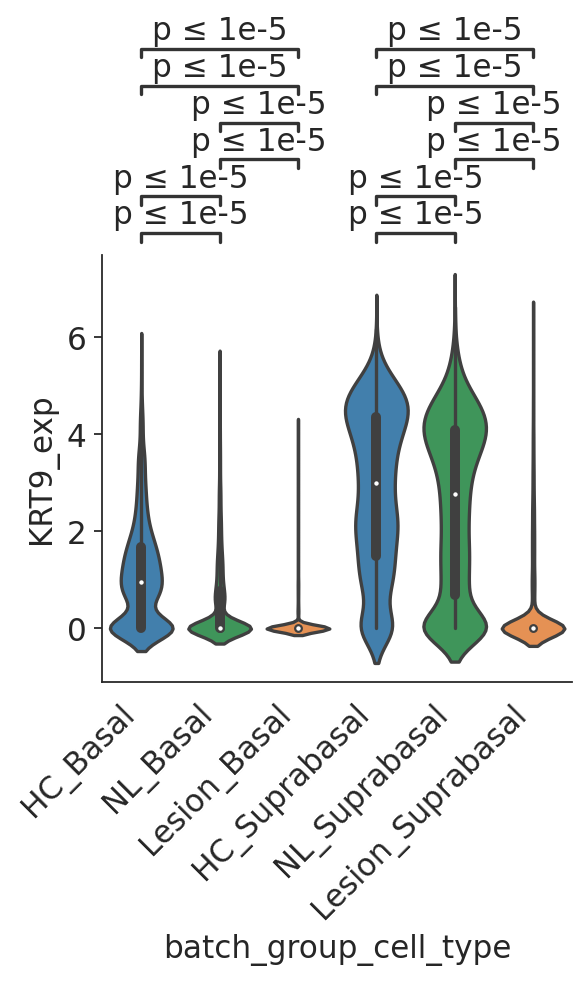

In [56]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'KRT9')
    plt.savefig('figures/fig2_4/KRT9_expression_between_batch_group.pdf')

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.758e-01 U_stat=6.437e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.244e-137 U_stat=2.464e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.758e-01 U_stat=6.437e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.244e-137 U_stat=2.464e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.549e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.217e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.549e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=2.217e+06
HC_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:2.399e-232 U_stat=1.499e+06
HC_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 

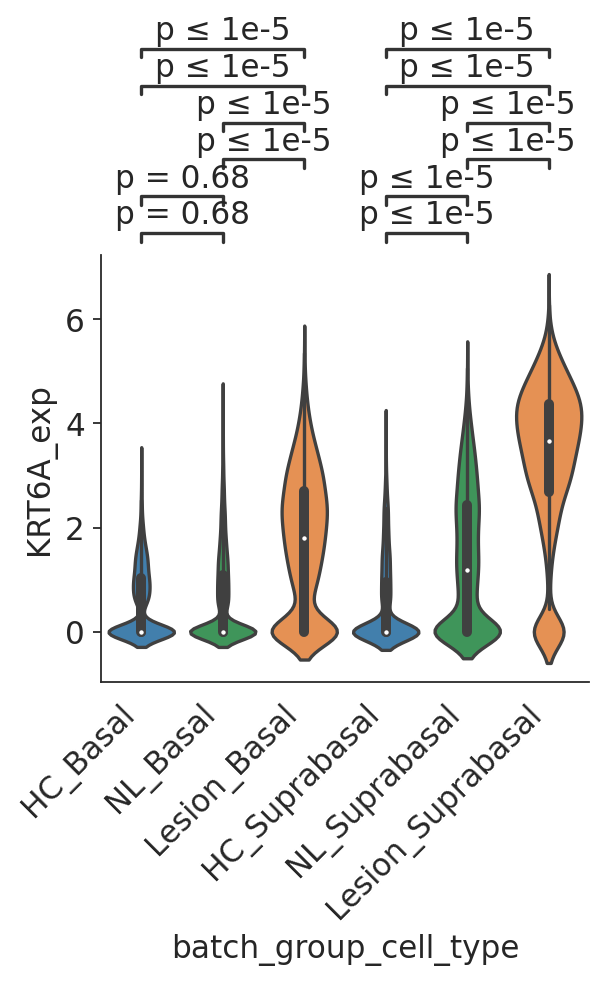

In [57]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'KRT6A')
    plt.savefig('figures/fig2_4/KRT6A_expression_between_batch_group.pdf')

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:4.085e-76 U_stat=4.758e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.210e-158 U_stat=2.286e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:4.085e-76 U_stat=4.758e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.210e-158 U_stat=2.286e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:4.077e-27 U_stat=7.627e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.266e-210 U_stat=3.684e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:4.077e-27 U_stat=7.627e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.266e-210 U_stat=3.684e+06
HC_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.914e-135 U_stat=1.867e+06
HC_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+0

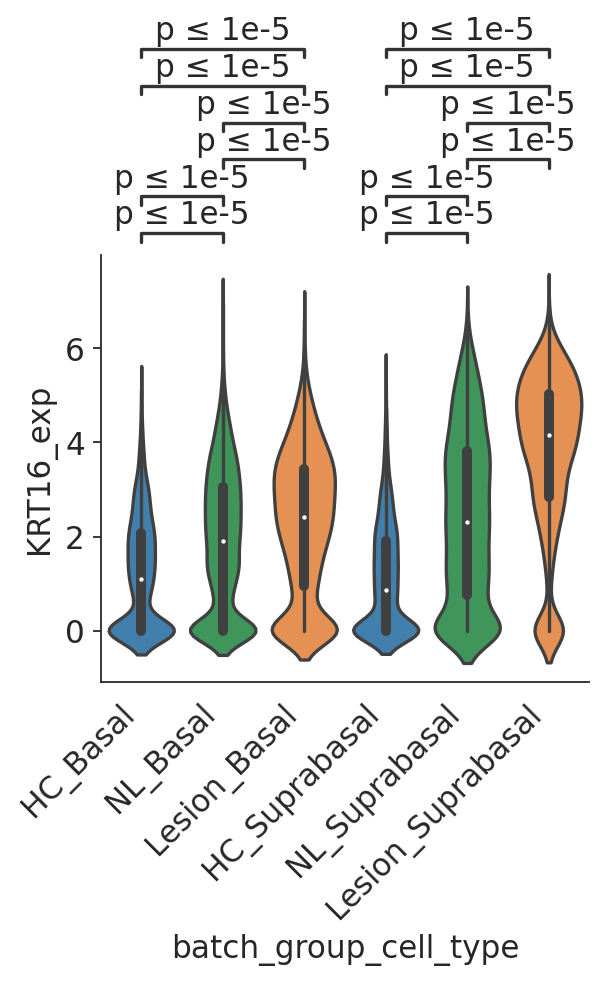

In [58]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'KRT16')
    plt.savefig('figures/fig2_4/KRT16_expression_between_batch_group.pdf')

HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.951e-28 U_stat=6.121e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.005e-94 U_stat=3.218e+06
HC_Basal vs. NL_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:6.951e-28 U_stat=6.121e+06
HC_Suprabasal vs. NL_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:3.005e-94 U_stat=3.218e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=5.121e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.179e+06
NL_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=5.121e+06
NL_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=3.179e+06
HC_Basal vs. Lesion_Basal: Mann-Whitney-Wilcoxon test two-sided, P_val:1.219e-287 U_stat=1.670e+06
HC_Suprabasal vs. Lesion_Suprabasal: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_

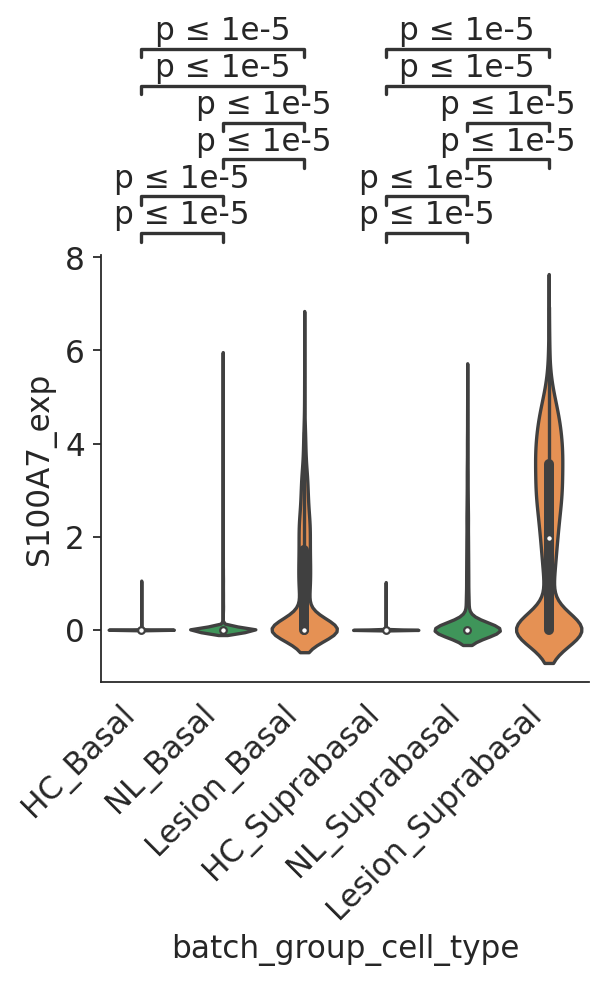

In [59]:
with rc_context({'figure.figsize': (4, 8)}):
    check_expression_between_batch_group(adata_ker, 'S100A7')
    plt.savefig('figures/fig2_4/S100A7_expression_between_batch_group.pdf')